# Using K-Nearest Neighbor to Predict SCOTUS Judging
> How to predict Justice Brennan's voting record with KNN

- toc: true 
- badges: true
- comments: true
- image: images/social_logo.png
- author: Charles Dobson
- categories: [python, artificial intelligence, machine learning, scikit-learn, KNN, k-nearest neighbor, law, litigation, analytics]

# Introduction

In previous posts, I've written about using a neural network to predict SCOTUS judging.{% fn 1 %} These posts were based on lesson 8 from  Prof. Wolfgang Alschner's fantastic course, [Data Science for Lawyers](https://www.datascienceforlawyers.org/). In this lesson, Prof. Alschner reviews several machine learning algorithms, including *k*-nearest neighbor, and explains how to use them to predict Justice Brennan's voting record. 

In the course, Prof. Alschner uses the R programming language. I don't know R, but I do know some Python. So I thought I'd use Python to apply *k*-nearest neighbor to the same Justice Brennan dataset. In this post, I show how to use the `KNeighborsClassifier()` class from scikit-learn for this purpose. 


# The Dataset

You can find an overview of the dataset in my earlier post, [Using Artificial Intelligence to Predict SCOTUS Judging](https://www.litkm.com/artificial%20intelligence/machine%20learning/deep%20learning/litigation/analytics/python/keras/neural%20networks/law/general/2021/02/11/AI_and_SCOTUS_Judging.html).

# Importing Dependencies

We begin by importing our dependencies.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

# Loading and Splitting the Dataset

We then load the dataset from a CSV and turn it into a DataFrame.

Next, we split this dataset into training features and labels, and testing features and labels. In lesson 8, the KNN model is trained on Justice Brennan's voting data prior to 1980 and tested on his voting data from 1980 and onwards. So we'll split our dataset accordingly.

In [2]:
dataset = 'https://raw.githubusercontent.com/litkm/WJBrennan-Voting/main/WJBrennan_voting.csv'
dataset = pd.read_csv(dataset)

#Features
x = dataset[['term', 'petitioner', 'respondent', 'jurisdiction', 'caseOrigin', 'caseSource', 'certReason', 'issue', 'issueArea']]

#Labels
y = dataset['vote']

#Features for training
X_train = x[x['term'] < 1980] 

#Features for testing
X_test = x[x['term'] > 1979]  

#Labels for training
Y_train = y.iloc[0:3368]      

#Labels for testing
Y_test = y.iloc[3367:4745]    


# Normalizing the Dataset

Now we must normalize the dataset. The features consist of numbers, all of varying ranges. So we need to scale them to use the same range.

The labels consist of one of two words, either "majority" or "minority". We must convert these categorical labels into either a "1" (majority) or a "0" (minority).

In [3]:
#
#Scale features
columns_for_standard = ['term', 'petitioner', 'respondent', 'jurisdiction', 'caseOrigin', 'caseSource', 'certReason', 'issue', 'issueArea']

ct = ColumnTransformer([('numeric', StandardScaler(), columns_for_standard)])

X_train = ct.fit_transform(X_train) 
X_test = ct.transform(X_test)

#Convert categorical labels to numbers
le = LabelEncoder()
Y_train = le.fit_transform(Y_train.astype(str))
Y_test = le.transform(Y_test.astype(str))

Now we are ready to create our model and train it on the dataset.

# The KNN Model

We instantiate our model using the `KNeighborsClassifier()` class from scikit-learn and train it on our dataset. 

Since the lesson in *Data Science for Lawyers* uses 3 nearest neighbors for predictions, we'll try the same at the outset.

In [4]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

# Testing the Model

Now let's test the model.

In [5]:
y_pred = knn.predict(X_test)

print("Accuracy:", metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.6444121915820029


Interestingly, this model does not perform as well as the KNN model in *Data Science for Lawyers*. Whereas our model is predicting Justice Brennan's voting record at about 64% accuracy, the model in the lesson from *DSL* reaches 69% (0.6879536). 

This is a significant difference. I'll return to this to explore further later in this post.

# Improving Model Accuracy

First, however, let's see if we can improve accuracy simply by adjusting the number of nearest neighbors the model is using to make predictions. As noted above, presently we are using 3.

In the code below, we test a range of nearest neighbor configurations, from 1-100. We then graph the results.



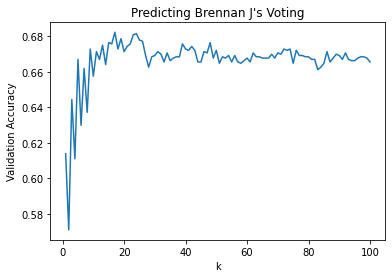

In [6]:
#
#Loop through nearest neighbor configurations ranging from 1-100
k = 1
accuracies = []
for k in range(1, 101):
  classifier = KNeighborsClassifier(n_neighbors = k)
  classifier.fit(X_train, Y_train)
  accuracies.append(classifier.score(X_test, Y_test))
  k += 1

#Plot results
k_list = range(1, 101)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Predicting Brennan J's Voting")
plt.plot(k_list, accuracies)
plt.show()

Now we can see some improvements. Accuracy tops out at slightly more than 68% when using around 17 nearest neighbors.

Notwithstanding improvement, this model is still not performing as well as the one in the *DSL* lesson.

I believe this difference in performance is likely due either to differences in the way
* the dataset was normalized; or
* the configuration of the model.

I don't propose to examine this exhaustively, but there is one avenue I'd like to explore. 

On further inspection, I don't think the dataset we are using is properly normalized. The features and labels are not scaled to the same range. Whereas the labels use a range of 0 to 1, the features do not. A quick inspection of the features makes this clear.

In [8]:
#
#Convert the features from numpy arrays to DataFrames in prep for min-max scaling, and ease of review
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train.head()

,0,1,2,3,4,5,6,7,8
0,-1.737337,-0.318522,-0.126546,-0.352654,-0.178368,-0.707061,0.473854,1.343053,1.342225
1,-1.737337,-1.392550,-0.126546,-0.352654,1.622782,1.635910,0.877430,1.068775,1.063071
2,-1.737337,0.362335,-0.860241,0.408229,-0.244379,-0.021932,-1.342238,0.781090,0.783918
3,-1.737337,-0.078783,2.485406,-0.352654,-1.140240,-0.664769,-1.140450,1.898592,1.900532
4,-1.737337,0.467820,-1.095023,0.408229,1.603922,1.635910,-1.342238,-0.334458,-0.332697


Let's see what happens when we re-scale the features to also range from 0 to 1. We will use a technique called min-max scaling.{% fn 2 %} 

In [9]:
#
#Apply min-max scaling to the training features
min = X_train.min().min()    
max = X_train.max().max()    
X_train = (X_train - min) / (max - min)

#Apply min-max scaling to the testing features
min = X_test.min().min()    
max = X_test.max().max()   
X_test = (X_test - min) / (max - min)


Let's inspect the features, post re-scaling.

In [10]:
X_train.head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.117871,0.133820,0.115035,0.129514,0.085592,0.183699,0.255909,0.255840
1,0.0,0.028644,0.133820,0.115035,0.279148,0.280239,0.217227,0.233123,0.232649
2,0.0,0.174434,0.072866,0.178247,0.124030,0.142511,0.032824,0.209223,0.209458
3,0.0,0.137788,0.350812,0.115035,0.049605,0.089106,0.049588,0.302062,0.302223
4,0.0,0.183198,0.053361,0.178247,0.277582,0.280239,0.032824,0.116547,0.116693


This looks encouraging. To confirm, we can review the minimum and maximum values from each column. First, we'll review the minimum values.

In [11]:
X_train.min()

0    0.000000
1    0.028644
2    0.051736
3    0.115035
4    0.042554
5    0.069430
6    0.016060
7    0.023569
8    0.023928
dtype: float64

Excellent. We've bottomed out at 0. Second, let's look at the max values.

In [12]:
X_train.max()

0    0.280976
1    0.426978
2    0.458090
3    1.000000
4    0.279148
5    0.281644
6    0.233991
7    0.302108
8    0.302223
dtype: float64

Perfect. We've topped out at 1. So we've confirmed all of the features are scaled to range between 0 and 1, same as the labels.

Now let's create a new model that is trained on this re-scaled dataset, and test it's accuracy.

In [12]:
#
#First, convert the labels to DataFrames from numpy arrays (because the features are now DataFrames)
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)

#Create and train the model
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, Y_train.values.ravel())

#Test the model's accuracy
y_pred = knn.predict(X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))

Accuracy: 0.6509433962264151


OK! We see some improvement. But we're still shy of 69% accuracy.

Let's try playing around again with the nearest neighbor configuration, same as before.

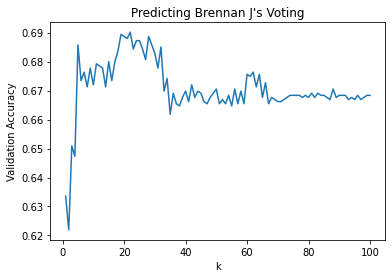

In [13]:
#
#Loop through nearest neighbor configurations ranging from 1-100
k = 1
accuracies = []
for k in range(1, 101):
  classifier = KNeighborsClassifier(n_neighbors = k)
  classifier.fit(X_train, Y_train.values.ravel())
  accuracies.append(classifier.score(X_test, Y_test))
  k += 1

#Plot results
k_list = range(1, 101)
plt.xlabel("k")
plt.ylabel("Validation Accuracy")
plt.title("Predicting Brennan J's Voting")
plt.plot(k_list, accuracies)
plt.show()

Boom! There we go. When configured to use around 25 nearest neighbors, this model hits a solid 69% accuracy and thus also now appears to perform *slightly* better than the one in the DSL lesson.

# Final Thoughts

I wonder how the performance of the KNN model in lesson 8 of *DSL* would vary if tested using a range of `k` configurations. If you have done this, or otherwise have any thoughts on the performance of these models, please reach out!

{{ 'See [Using Artificial Intelligence to Predict SCOTUS Judging](https://www.litkm.com/artificial%20intelligence/machine%20learning/deep%20learning/litigation/analytics/python/keras/neural%20networks/law/general/2021/02/11/AI_and_SCOTUS_Judging.html) and [Parsing a Neural Network to Predict SCOTUS Judging](https://www.litkm.com/artificial%20intelligence/machine%20learning/deep%20learning/litigation/analytics/python/keras/neural%20networks/2021/02/26/Parsing_Model.html).' | fndetail: 1 }}

{{ 'For more on min-max scaling, see my earlier post, [Finding Analogous Cases with K-Nearest Neighbor](https://www.litkm.com/python/machine%20learning/scikit-learn/knn/k-nearest%20neighbor/law/2021/10/19/Part_2_KNN_&_Legal_Data-v2.html).' | fndetail: 2}}
